In [1]:
from jax_models import *
import numpy as np

# models 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from tqdm import tqdm

# Overview / Run Model

In [384]:
nsteps = 1000
npts = 500
domain_length =50
modes = 16

model = KuramotoSivashinsky(s= npts, l = domain_length, M = modes)
model.precompute_constants();

ar = np.zeros((nsteps, npts))
ar[0, :] = np.random.randn(npts)
ar[1, :] = model.step(ar[0, :])
for i in range(2, nsteps):
    ar[i] = model.step(ar[i-1, :])

# plt.plot(model.step(np.random.randn(128)))

Text(0, 0.5, 'space (x)')

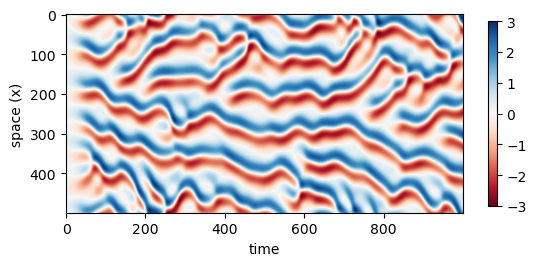

In [385]:
plt.imshow(np.transpose(ar), cmap = "RdBu", vmin = -3, vmax = 3)
plt.colorbar(shrink = .5)
plt.xlabel("time")
plt.ylabel("space (x)")

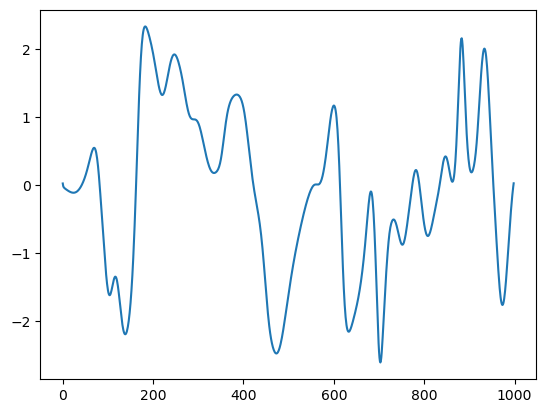

In [90]:
plt.plot(ar[1:, int(np.floor(npts/2))])

# Train Linear Regression Model

In [155]:
# build regression model 

# get training data
num_training = 1000
rand_times = np.random.randint(100, nsteps, num_training)
rand_points = np.random.randint(0, npts, num_training)

X, y = [], []

for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
    #print(idx, point)
    X.append(ar[idx - 20:idx, point])
    y.append(ar[idx, point])

X = np.array(X)
y = np.array(y)

In [156]:
# build linear regression model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))



9.74805838561406e-10


In [186]:
class LinearRegressionModel:
    def __init__(self, num_training, hist_length, rollout, nsteps = 1000, npts = 500, domain_length = 50, modes = 16):
        # data parameters
        self.num_training = num_training
        self.hist_length = hist_length
        self.rollout = rollout

        # model parameters
        self.nsteps = nsteps
        self.npts = npts
        self.domain_length = domain_length
        self.modes = modes
        self.setup()

    def run_forward_models(self):
        """Runs train and test KS"""
        self.train_model = KuramotoSivashinsky(s= self.npts, l = self.domain_length, M = self.modes)
        self.train_model.precompute_constants();

        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i-1, :])
        self.train_data = ar

        # repeat for test data 
        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i-1, :])
        self.test_data = ar

    def build_training_data(self):
        """Extracts training data"""
        rand_times = np.random.randint(100, self.nsteps, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            X.append(self.train_data[idx - self.hist_length:idx, point])
            y.append(self.train_data[idx, point])

        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def build_testing_data(self):
        """Extracts testing data"""
        rand_times = np.random.randint(100, self.nsteps, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            X.append(self.test_data[idx - self.hist_length:idx, point])
            y.append(self.test_data[idx, point])

        self.X_test = np.array(X)
        self.y_test = np.array(y)

    def linreg(self):
        """Trains the model"""
        self.reg = LinearRegression().fit(self.X_train, self.y_train)

    def test_linreg(self):
        """Tests the model"""
        y_pred = self.reg.predict(self.X_test)
        self.mse = mean_squared_error(self.y_test, y_pred)

    def setup(self):
        self.run_forward_models()
        self.build_training_data()
        self.build_testing_data()
        self.linreg()
        self.test_linreg()

# run the model
linreg = LinearRegressionModel(1000, 20, 1)
print(linreg.mse)

4.782354696692796e-09


/var/folders/4d/j6w5sd4514x02scwb1gkq_900000gn/T/ipykernel_2954/818017280.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.mean(history_results, axis = 1)))


Text(0.5, 1.0, 'Single Time-step Linear Regression Model Performance vs Rollout')

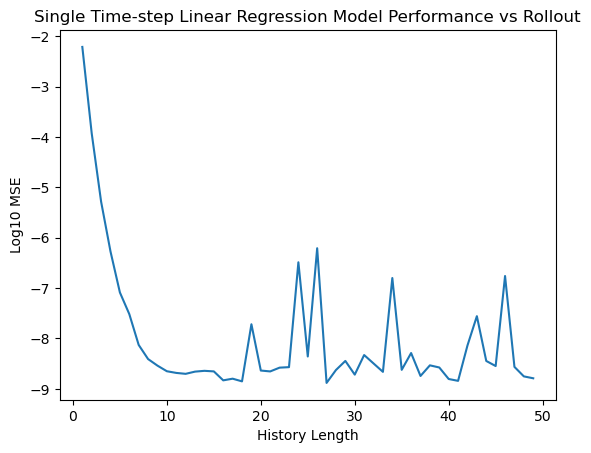

In [181]:
history_results = np.zeros((50, 20))
for hist_len in range(1, 50):
    samples = np.zeros(20)
    for trial in range(20):    
        linreg = LinearRegressionModel(1000, hist_len, 1)
        samples[trial] = linreg.mse
    history_results[hist_len, :] = samples

plt.plot(np.log10(np.mean(history_results, axis = 1)))
#plt.fill_between(range(20), np.log10(np.mean(history_results, axis = 1)) - np.log10(np.std(history_results, axis = 1)), np.log10(np.mean(history_results, axis = 1)) + np.log10(np.std(history_results, axis = 1)), alpha = .5)
plt.xlabel("History Length")
plt.ylabel("Log10 MSE")
plt.title("Single Time-step Linear Regression Model Performance vs Rollout")

In [113]:
# extend to rollout prediction on multiple time steps 
class LinearRegressionModel:
    def __init__(self, num_training, hist_length, rollout, nsteps = 1000, npts = 500, domain_length = 50, modes = 16):
        # data parameters
        self.num_training = num_training
        self.hist_length = hist_length
        self.rollout = rollout

        # model parameters
        self.nsteps = nsteps
        self.npts = npts
        self.domain_length = domain_length
        self.modes = modes


        self.setup()

    def run_forward_models(self):
        """Runs train and test KS"""
        self.train_model = KuramotoSivashinsky(s= self.npts, l = self.domain_length, M = self.modes)
        self.train_model.precompute_constants();

        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i-1, :])
        self.train_data = ar

        # repeat for test data 
        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i-1, :])
        self.test_data = ar

    def build_training_data(self):
        """Extracts training data"""
        rand_times = np.random.randint(100, self.nsteps - self.rollout, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            X.append(self.train_data[idx - self.hist_length:idx, point])
            # y data is the next #rollout points
            y.append(self.train_data[idx:idx + self.rollout, point])

        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def build_testing_data(self):
        """Extracts testing data"""
        rand_times = np.random.randint(100, self.nsteps - self.rollout, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            # print(self.test_data[idx - self.hist_length:idx, point].shape)
            # print(self.test_data[idx:idx + self.rollout, point].shape)

            X.append(self.test_data[idx - self.hist_length:idx, point])
            y.append(self.test_data[idx:idx + self.rollout, point])

        self.X_test = np.array(X)
        self.y_test = np.array(y)

    def linreg(self):
        """Trains the model"""
        self.reg = LinearRegression().fit(self.X_train, self.y_train[:, 0])

    def test_linreg(self):
        """Tests the model"""
        y_pred = self.reg.predict(self.X_test)
        self.mse = mean_squared_error(self.y_test[:, 0], y_pred)

    def rollout_error(self):
        X_rollout = self.X_test.copy()
        for i in range(self.rollout):
            # predict
            t = self.reg.predict(X_rollout[:, i:])
            # roll forward
            X_rollout = np.concatenate((X_rollout, t.reshape(-1, 1)), axis = 1)

        self.rollout_mse = mean_squared_error(self.y_test, X_rollout[:, -self.rollout:])
        #print(X_rollout[:, :self.rollout].shape)
        #print(X_rollout.shape, self.X_test.shape, self.y_test.shape, X_rollout[:, -self.rollout:].shape)

    def setup(self):
        self.run_forward_models()
        self.build_training_data()
        self.build_testing_data()
        self.linreg()
        self.test_linreg()

# run the model
linreg = LinearRegressionModel(10000, 20, 600)
linreg.rollout_error()
linreg.mse, linreg.rollout_mse


(6.894633063680084e-10, 1.591529815729718)

In [271]:
# evaulate results as a function of rollout length 
rollout_mse = []

for rollout in range(1, 1000, 20):
    try:
        linreg = LinearRegressionModel(1000, 10, rollout)
        linreg.rollout_error()
        rollout_mse.append(linreg.rollout_mse)
    except:
        print("Failed at rollout length: ", rollout)
        rollout_mse.append(np.nan)

Failed at rollout length:  901
Failed at rollout length:  921
Failed at rollout length:  941
Failed at rollout length:  961
Failed at rollout length:  981


Text(0.5, 1.0, 'Rollout Prediction Performance')

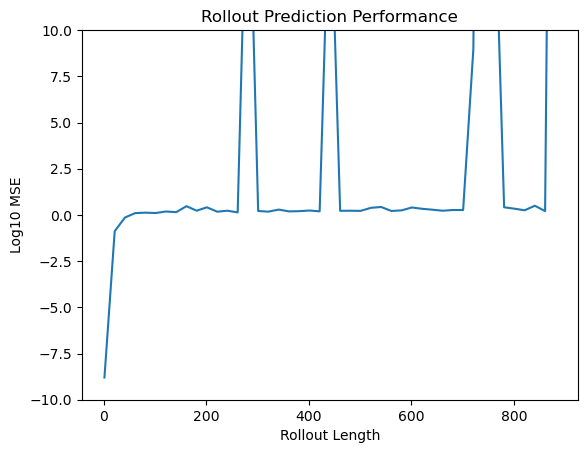

In [272]:
plt.plot(range(1, 1000, 20), np.log10(rollout_mse))
plt.ylim(-10, 10)
plt.xlabel("Rollout Length")
plt.ylabel("Log10 MSE")
plt.title("Rollout Prediction Performance")

In [114]:
nsteps = 1000
npts = 500
domain_length =50
modes = 16

model = KuramotoSivashinsky(s= npts, l = domain_length, M = modes)
model.precompute_constants();

ar = np.zeros((nsteps, npts))
np.random.seed(107)
ar[0, :] = np.random.randn(npts)
ar[1, :] = model.step(ar[0, :])

for i in range(2, nsteps):
    ar[i] = model.step(ar[i-1, :])

# build regression model
history_length = 80
linreg = LinearRegressionModel(10000, history_length, 1, nsteps = 1000, npts = 500, domain_length = 50, modes = 16)
linreg.rollout_error()

predictions = ar.copy()

for t in range(200, nsteps):
    predictions[t, :] = linreg.reg.predict(np.transpose(predictions[t - history_length:t, :]))

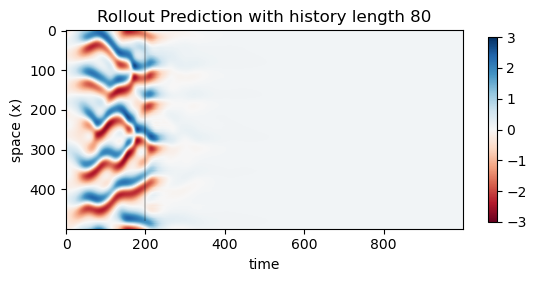

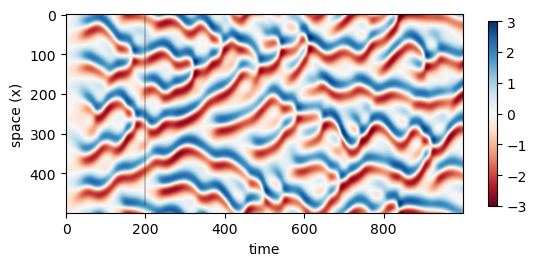

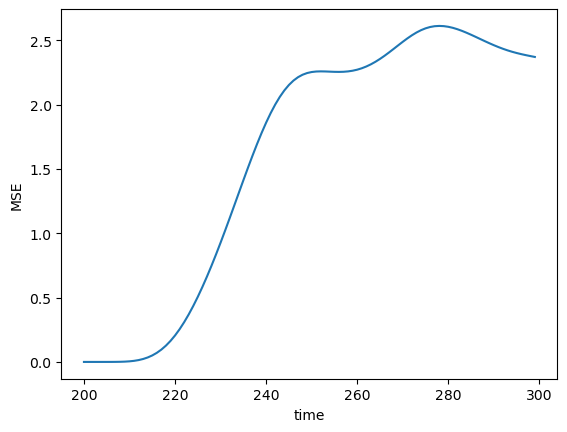

In [116]:
plt.imshow(np.transpose(predictions), cmap = "RdBu", vmin = -3, vmax = 3)
plt.colorbar(shrink = .5)
plt.vlines((200, 0), ymin = 0, ymax = 480, color = "black", linewidth = .3)
plt.xlabel("time")
plt.ylabel("space (x)")
plt.title(f"Rollout Prediction with history length {history_length}")
plt.show()

plt.imshow(np.transpose(ar), cmap = "RdBu", vmin = -3, vmax = 3)
plt.colorbar(shrink = .5)
plt.vlines((200, 0), ymin = 0, ymax = 480, color = "black", linewidth = .3)

plt.xlabel("time")
plt.ylabel("space (x)")
plt.show()

# plot error 
lr_error_timeseries = np.mean((ar - predictions)**2, axis = 1)
plt.plot(range(200, 300), lr_error_timeseries[200:300])
plt.xlabel("time")
plt.ylabel("MSE")
plt.show()

# Repeat but with a RNN model

In [129]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape)
        # Use the last output of the LSTM to make the prediction
        predictions = self.fc(lstm_out)  # last time step's output

        return predictions
    

class SimpleLinearRegression(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

class RNNModelFramework:
    def __init__(self, num_training, hist_length, rollout, 
                 nsteps=1000, npts=500, domain_length=50, modes=16, 
                 hidden_size=64, num_layers=1, batch_size = 64):
        # data parameters
        self.num_training = num_training
        self.hist_length = hist_length
        self.rollout = rollout

        # model parameters
        self.nsteps = nsteps
        self.npts = npts
        self.domain_length = domain_length
        self.modes = modes

        # RNN parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        self.setup()

    def run_forward_models(self):
        """Runs train and test KS"""
        self.train_model = KuramotoSivashinsky(s=self.npts, l=self.domain_length, M=self.modes)
        self.train_model.precompute_constants()

        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i - 1, :])
        self.train_data = ar

        # repeat for test data
        ar = np.zeros((self.nsteps, self.npts))
        ar[0, :] = np.random.randn(self.npts)
        ar[1, :] = self.train_model.step(ar[0, :])
        for i in range(2, self.nsteps):
            ar[i] = self.train_model.step(ar[i - 1, :])
        self.test_data = ar

    def build_training_data(self):
        """Extracts training data"""
        rand_times = np.random.randint(100, self.nsteps - self.rollout, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            X.append(self.train_data[idx - self.hist_length:idx, point])
            y.append(self.train_data[idx:idx + self.rollout, point])

        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def build_testing_data(self):
        """Extracts testing data"""
        rand_times = np.random.randint(100, self.nsteps - self.rollout, self.num_training)
        rand_points = np.random.randint(0, self.npts, self.num_training)

        X, y = [], []

        for i, (idx, point) in enumerate(zip(rand_times, rand_points)):
            X.append(self.test_data[idx - self.hist_length:idx, point])
            y.append(self.test_data[idx:idx + self.rollout, point])

        self.X_test = np.array(X)
        self.y_test = np.array(y)

    def rnn_train(self):
        # Convert the data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(self.X_train)  # Add feature dimension
        y_train_tensor = torch.FloatTensor(self.y_train)
        print(X_train_tensor.shape, y_train_tensor.shape)

        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        input_size = self.hist_length  # Since the input is a single point at each time step
        output_size = 1  # Predicting a single value at each time step

        # Define RNN model
        self.model = RNNModel(input_size=input_size, hidden_size=self.hidden_size, output_size=output_size, num_layers=self.num_layers)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Train the RNN model
        num_epochs = 100
        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                #print(X_batch.shape, y_batch.shape)
                #return 0
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                print(outputs.shape, y_batch.shape)
                loss = 0 
                for i in range(self.rollout):

                    loss += criterion(outputs[:, i], y_batch[:, i])
                #loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

    def simple_linear_regression_train(self):
        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(self.X_train)
        y_train_tensor = torch.FloatTensor(self.y_train[:, 0])

        # Create a dataset and dataloader for batching
        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Define the model
        input_size = self.X_train.shape[1]
        model = SimpleLinearRegression(input_size)

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.1)

        # Training loop
        num_epochs = 300
        for epoch in tqdm(range(num_epochs)):
            model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


    def rnn_test(self):
        """Tests the RNN model"""
        X_test_tensor = torch.FloatTensor(self.X_test)  # Add feature dimension
        self.model.eval()
        with torch.no_grad():
            y_pred_tensor = self.model(X_test_tensor)
        y_pred = y_pred_tensor.numpy()
        self.mse = mean_squared_error(self.y_test[:, 0], y_pred)

    def rollout_error(self):
        X_rollout = self.X_test.copy()
        X_rollout_tensor = torch.FloatTensor(X_rollout).unsqueeze(-1)  # Add feature dimension
        self.model.eval()
        with torch.no_grad():
            for i in range(self.rollout):
                # predict
                t_tensor = self.model(X_rollout_tensor)
                t = t_tensor.numpy()
                # roll forward
                X_rollout = np.concatenate((X_rollout, t.reshape(-1, 1)), axis=1)
                X_rollout_tensor = torch.FloatTensor(X_rollout).unsqueeze(-1)  # Update tensor

        self.rollout_mse = mean_squared_error(self.y_test, X_rollout[:, -self.rollout:])

    def setup(self):
        self.run_forward_models()
        self.build_training_data()
        self.build_testing_data()
        self.rnn_train()
        # self.rnn_test()

# run the model
rnn_model = RNNModelFramework(1000, 80, 2, batch_size = 128)
# linreg_rnn.rollout_error()
# print(linreg_rnn.mse, linreg_rnn.rollout_mse)


torch.Size([1000, 80]) torch.Size([1000, 2])


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [126]:
nsteps = 1000
npts = 500
domain_length =50
modes = 16

model = KuramotoSivashinsky(s= npts, l = domain_length, M = modes)
model.precompute_constants();

ar = np.zeros((nsteps, npts))
np.random.seed(107)
ar[0, :] = np.random.randn(npts)
ar[1, :] = model.step(ar[0, :])

for i in range(2, nsteps):
    ar[i] = model.step(ar[i-1, :])

# build regression model
history_length = 80
# linreg = LinearRegressionModel(10000, history_length, 1, nsteps = 1000, npts = 500, domain_length = 50, modes = 16)
# linreg.rollout_error()

predictions = torch.FloatTensor(np.transpose(ar.copy()))

for t in range(200, nsteps):
    predictions[:, t] = rnn_model.model(predictions[:, t - history_length:t]).squeeze(1)

predictions = predictions.detach().numpy()


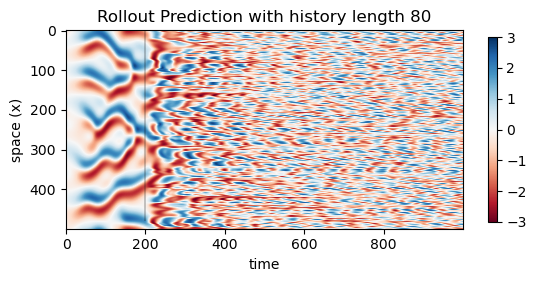

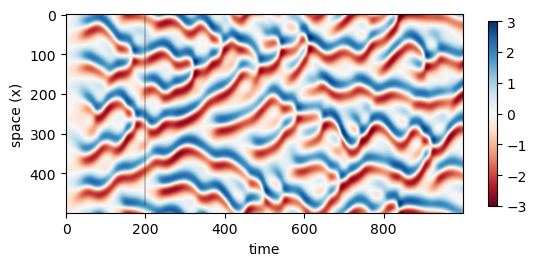

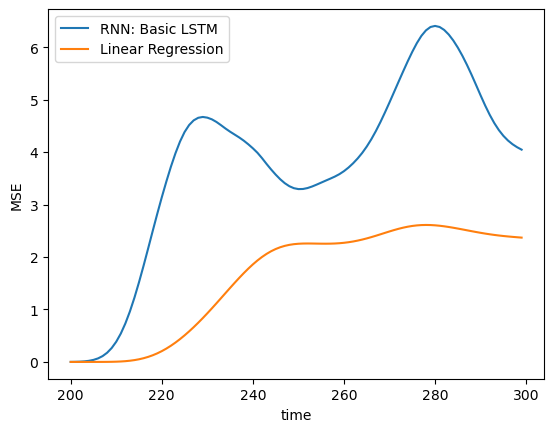

In [127]:
plt.imshow(predictions, cmap = "RdBu", vmin = -3, vmax = 3)
plt.colorbar(shrink = .5)
plt.vlines((200, 0), ymin = 0, ymax = 480, color = "black", linewidth = .3)
plt.xlabel("time")
plt.ylabel("space (x)")
plt.title(f"Rollout Prediction with history length {history_length}")
plt.show()

plt.imshow(np.transpose(ar), cmap = "RdBu", vmin = -3, vmax = 3)
plt.colorbar(shrink = .5)
plt.vlines((200, 0), ymin = 0, ymax = 480, color = "black", linewidth = .3)

plt.xlabel("time")
plt.ylabel("space (x)")
plt.show()

# plot error 
error = np.mean((np.transpose(ar) - predictions)**2, axis = 0)
plt.plot(range(200, 300), error[200:300], label = "RNN: Basic LSTM")
plt.plot(range(200, 300), lr_error_timeseries[200:300], label = "Linear Regression")
plt.xlabel("time")
plt.ylabel("MSE")
plt.legend()
plt.show()